In [1]:
from libdatasets import *
import librun
import libstop
from importlib import reload
from libadversarial import uncertainty_stop
from libstop import rank_stop_conds
from dotenv import load_dotenv; load_dotenv();

In [2]:
def plot_stop(plots, classifiers, stop_conditions, stop_results, scale='linear', figsize=(26, 4), lines=None, ssncut_values = None):
    from librun import plot
    import matplotlib.pyplot as plt
    reload(libstop)
    from libstop import SSNCut
    figaxes = plot(plots, ret=True, sort=False, extra=1, scale=scale, figsize=figsize)
    for i, (fig, ax) in enumerate(figaxes):
        clfs = classifiers[i]
        config = plots[i][0]
        metrics = plots[i][1]
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

        ssncut_values = ssncut_values or SSNCut_values(clfs[0], X_unlabelled, Y_oracle)
        ax[-1].plot(metrics[0].x, ssncut_values)
        
        fig.legend()
        fig.tight_layout()
        return ssncut_values

In [61]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("rcv1", wrap(rcv1, None)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [62]:
reload(librun)
results = librun.run(matrix, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-ebad9c7e-ef2a-4ae6-bc0a-1d58c1676d32.json']


Experiment:   0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
import libactive; reload(libactive); import libdatasets; from libactive import active_split; from sklearn.utils import check_random_state; 

In [82]:
import traceback
reload(libstop); from libstop import *
for j, (conf, results) in enumerate(results_plots):
    #conf = results_plots[0][0]
    #results = results_plots[0][1]
    X, y = getattr(libdatasets, conf.dataset_name)(None)
    unlabelled_pools = []
    y_oracles = []
    # WARN: This is not the same as the job numbers! Unfortunately they're not easily accessible
    for i in range(len(results)):
        _, X_unlabelled, _, Y_oracle, _, _ = active_split(
            X, y, labeled_size=conf.meta['labelled_size'], test_size=conf.meta['test_size'], random_state=check_random_state(i), ensure_y=conf.meta['ensure_y']
        )
        unlabelled_pools.append(X_unlabelled)
        y_oracles.append(Y_oracle)

    for i in range(len(results)):
        try:
            print(f"Trying {conf.dataset_name} run {i}")
            for x in reconstruct_unlabelled_new(classifiers[j][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]):
                pass
        except Exception as e:
            print(f"Dataset {conf.dataset_name} run {i} failed: {e}")
            traceback.print_exc()
            raise e

Trying rcv1 run 0
Trying rcv1 run 1
Trying webkb run 0
Trying webkb run 1
Trying spamassassin run 0
Trying spamassassin run 1


In [72]:
np.arange(30)[-10:]

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

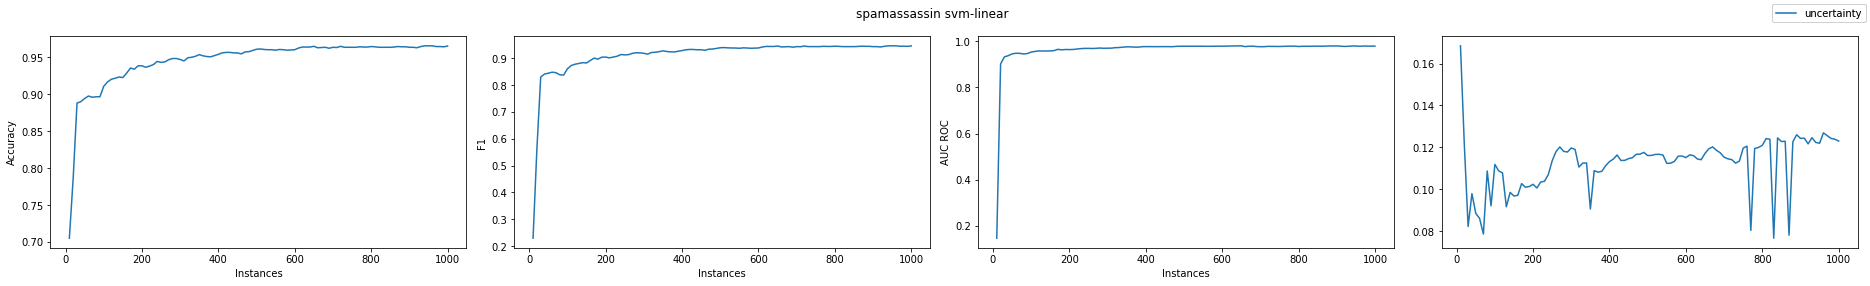

In [47]:
ssncut_values = plot_stop(results_plots, classifiers, None, None, ssncut_values=ssncut_values)

In [42]:
reload(libstop)
from libstop import ZPS, stabilizing_predictions, SSNCut
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers, conditions={
    "ZPS2": partial(ZPS, order=2),
    "SSNCut": SSNCut,
    "stabilizing_predictions": stabilizing_predictions
})

0/100
SSNCut took 0.34399999999914144
1/100
SSNCut took 0.3440000000009604
2/100
SSNCut took 0.40600000000085856
3/100
SSNCut took 0.4529999999995198
4/100
SSNCut took 0.43800000000010186
5/100
SSNCut took 0.6090000000003783
6/100
SSNCut took 0.48400000000037835
7/100
SSNCut took 0.5
8/100
SSNCut took 0.5
9/100
SSNCut took 0.5159999999996217
10/100
SSNCut took 0.5779999999995198
11/100
SSNCut took 0.5469999999986612
12/100
SSNCut took 0.5619999999998981
13/100
SSNCut took 0.6090000000003783
14/100
SSNCut took 0.5780000000013388
15/100
SSNCut took 0.625
16/100
SSNCut took 0.6090000000003783
17/100
SSNCut took 0.6560000000008586
18/100
SSNCut took 0.6720000000004802
19/100
SSNCut took 0.8589999999985594
20/100
SSNCut took 0.6880000000001019
21/100
SSNCut took 0.7029999999995198
22/100
SSNCut took 0.6410000000014406
23/100
SSNCut took 0.6720000000004802
24/100
SSNCut took 0.6869999999998981
25/100
SSNCut took 0.6869999999998981
26/100
SSNCut took 0.75
27/100
SSNCut took 0.8130000000001019

C:\Users\Zac\AppData\Local\pypoetry\Cache\virtualenvs\research-KKf5lz0r-py3.8\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SSNCut took 0.9529999999995198
66/100
SSNCut took 0.9850000000005821
67/100
SSNCut took 1.0
68/100
SSNCut took 1.0159999999996217
69/100
SSNCut took 1.0309999999990396
70/100
SSNCut took 1.0470000000004802
71/100
SSNCut took 1.014999999999418
72/100
SSNCut took 0.9680000000007567
73/100
SSNCut took 0.9840000000003783
74/100
SSNCut took 0.9840000000003783
75/100
SSNCut took 1.0159999999996217
76/100
SSNCut took 1.014999999999418
77/100
SSNCut took 1.0
78/100
SSNCut took 1.0
79/100
SSNCut took 0.9690000000009604
80/100
SSNCut took 0.9840000000003783
81/100
SSNCut took 1.0159999999996217
82/100
SSNCut took 0.9839999999985594
83/100
SSNCut took 1.0
84/100
SSNCut took 1.0159999999996217
85/100
SSNCut took 0.9690000000009604
86/100
SSNCut took 0.9840000000003783
87/100
SSNCut took 0.9530000000013388
88/100
SSNCut took 0.9690000000009604
89/100
SSNCut took 1.1090000000003783
90/100
SSNCut took 1.0930000000007567
91/100
SSNCut took 1.125
92/100
SSNCut took 1.0940000000009604
93/100
SSNCut took

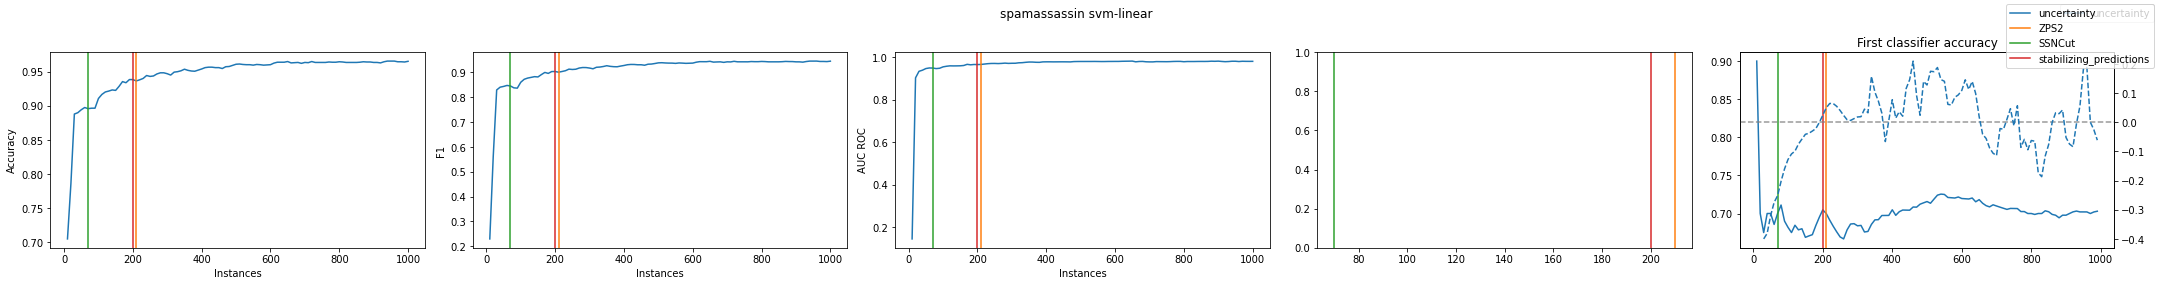

In [44]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4), scale='linear') # scale='logit'